In [37]:
import pandas as pd
import re
import torch
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import font_manager
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline, TextClassificationPipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data 載入資料</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Information 資料集資訊</div>

# PTT AI 討論資料集介紹

## 資料集概覽

此資料集包含有關 AI 的討論，收集自台灣的社群媒體平台 PTT。資料收集範圍從 2022 年 1 月 1 日到 2024 年 5 月 31 日，共包含 2,172 筆資料。

## 資料欄位說明

資料集包含以下 11 個欄位：

1. `system_id`: 系統編號，總共 2172 筆，無空值。
2. `artComment`: 文章評論，總共 2172 筆，無空值。
3. `artDate`: 文章日期，總共 2172 筆，無空值。
4. `insertedDate`: 插入日期，總共 2172 筆，無空值。
5. `artContent`: 文章內容，總共 2172 筆，無空值。
6. `artCatagory`: 文章類別，總共 2172 筆，無空值。
7. `dataSource`: 資料來源，總共 2172 筆，無空值，全部來自 PTT。
8. `artPoster`: 發文者，總共 2172 筆，無空值。
9. `artTitle`: 文章標題，總共 2172 筆，無空值。
10. `artUrl`: 文章網址，總共 2172 筆，無空值。

## 記憶體使用情況

- 資料集大小： 186.8+ KB
- 資料型態：整數 (int64) 1 欄，物件 (object) 9 欄

In [4]:
df = pd.read_csv('data/ptt_ai_221130to240531.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,ggglu,Finance,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,kria5304,Finance,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""fill725258"",...",36.224.200.45,2023-02-15 01:06:37,ptt
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,BangBang5566,Finance,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Laviathan"", ...",42.70.143.5,2023-10-31 01:10:55,ptt
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,howdigh,job,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,[],125.230.247.67,2022-01-04 00:58:48,ptt


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2172 non-null   int64 
 1   artUrl        2172 non-null   object
 2   artTitle      2172 non-null   object
 3   artDate       2172 non-null   object
 4   artPoster     2172 non-null   object
 5   artCatagory   2172 non-null   object
 6   artContent    2172 non-null   object
 7   artComment    2172 non-null   object
 8   e_ip          2126 non-null   object
 9   insertedDate  2172 non-null   object
 10  dataSource    2172 non-null   object
dtypes: int64(1), object(10)
memory usage: 186.8+ KB


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the font 載入字型</div>

In [6]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Data Preprocessing 資料前處理</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Data Cleaning 資料清理</div>

In [7]:
# 複製原始資料集
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artUrl', 'artPoster', 'artCatagory', 'artComment', 'insertedDate', 'dataSource', 'e_ip']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10) 

,artTitle,artDate,artContent,sentence
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,【實習】，【公司名稱】Influx FinTech 普匯金融科技。【工作職缺】Fintech...
1,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21 02:29:23,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威，，董事長呂...
2,[新聞]央行徵才月薪最高86K,2023-02-14 11:45:19,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,週二 上午6:32，擁抱「金」飯碗的機會來了。中央銀行近日公開徵才，開出的職缺包括「經濟金...
3,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31 00:48:54,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...,證交所徵才開創數位驅動時代 報名至11/17止。中央社，2023年10月30日 週一 下午1...
4,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03 07:22:51,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...
5,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-05 15:59:05,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...
6,[北部]林口長庚醫院醫療AI中心誠徵統計分析助理,2022-01-13 14:05:16,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...
7,[台北]國立臺灣師範大學教育部計畫專任助理,2022-01-17 09:28:27,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...
8,[台北]三軍總醫院AIoT中心誠徵博士級研究員,2022-01-20 16:52:39,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...
9,"[台北]4w+薪商標專利業務行銷撰稿,專利師",2022-01-21 18:30:13,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「，就業服務法，」、，「，性別平等工作法，」、，「，勞基法，」與其他法律...


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Tokenization Sentence 分詞</div>

In [8]:
# 去除一些不需要的欄位
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")
meta_data = clear_df.explode('sentence').reset_index(drop=True)

meta_data['sentence'] = meta_data['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

meta_data.head()

,artTitle,artDate,artContent,sentence
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習
1,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,公司名稱普匯金融科技
2,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺
3,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,徵求條件
4,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,商管相關科系或曾經接觸相關領域


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Sentiment Analysis 情感分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Setup the Sentiment Analysis Model 設定情感分析模型</div>

In [11]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"
model = pipeline('sentiment-analysis', model=model_name, device=0)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Sentiment Analysis 情感分析</div>

In [12]:
tqdm.pandas()

# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = meta_data['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = meta_data['sentence'].progress_apply(analyze_sentiment)

# 輸出結果
results_df.head()

100%|██████████| 155733/155733 [33:34<00:00, 77.31it/s] 


,sentence,label,score
0,實習,star 4,0.628665
1,公司名稱普匯金融科技,star 4,0.446098
2,工作職缺,star 4,0.833312
3,徵求條件,star 4,0.897125
4,商管相關科系或曾經接觸相關領域,star 4,0.690813


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Merge the Sentiment Analysis Results 合併情感分析結果</div>

In [34]:
# 合併情感分析結果
sentiment_df = meta_data.copy()

assert len(sentiment_df) == len(results_df)

# 將情感分析結果合併到原始資料集 on sentence
sentiment_df = pd.concat([sentiment_df, results_df], axis=1)

# 去除第四個 (重複的 sentence 欄位)
sentiment_df = sentiment_df.loc[:,~sentiment_df.columns.duplicated()]

sentiment_df.head()

,artTitle,artDate,artContent,sentence,label,score
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習,star 4,0.628665
1,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,公司名稱普匯金融科技,star 4,0.446098
2,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺,star 4,0.833312
3,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,徵求條件,star 4,0.897125
4,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,商管相關科系或曾經接觸相關領域,star 4,0.690813


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Save the Sentiment Analysis Results 儲存情感分析結果</div>

In [35]:
sentiment_df.to_csv('data/bert_sentiment_analysis.csv', index=False)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Data Visualization 資料視覺化</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the Sentiment Analysis Results 載入情感分析結果</div>

In [36]:
sentiment_df = pd.read_csv('data/bert_sentiment_analysis.csv')
sentiment_df.head()

,artTitle,artDate,artContent,sentence,label,score
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習,star 4,0.628665
1,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,公司名稱普匯金融科技,star 4,0.446098
2,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺,star 4,0.833312
3,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,徵求條件,star 4,0.897125
4,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,商管相關科系或曾經接觸相關領域,star 4,0.690813


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Sentiment Analysis Results Visualization 情感分析結果視覺化</div>

In [51]:
sentiment_df.value_counts('label')

label
star 4    114642
star 3     17448
star 5     11553
star 2      6427
star 1      5663
Name: count, dtype: int64

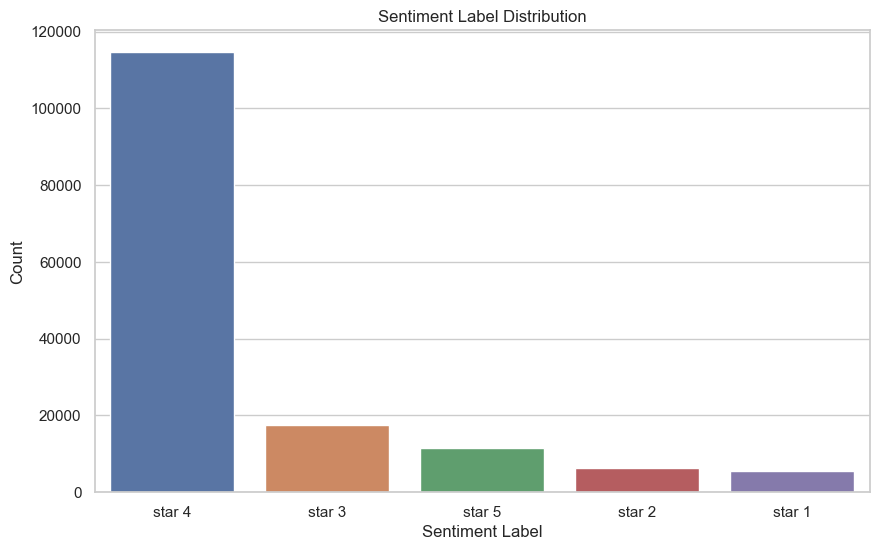

In [52]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 設置圖表大小
plt.figure(figsize=(10, 6))

# 繪製情感標籤的分佈柱狀圖
sns.countplot(x='label', data=sentiment_df)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

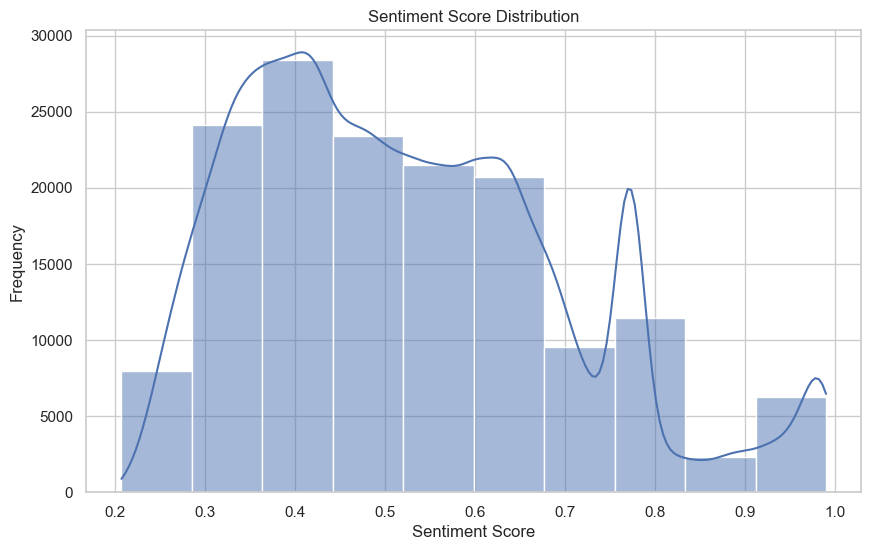

In [53]:
# 繪製情感分數的分佈直方圖
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_df['score'], bins=10, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

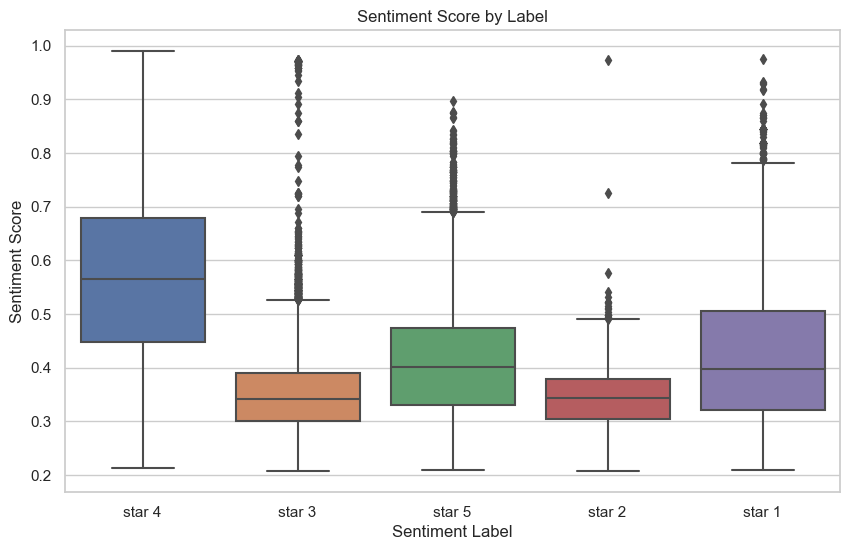

In [54]:
# 繪製情感分數隨情感標籤的箱線圖
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='score', data=sentiment_df)
plt.title('Sentiment Score by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()

### 1. Sentiment Label Distribution (情感標籤分佈)
從第一張圖中可以看到：
- Star 4 標籤的數量遠遠超過其他標籤，表明在分析的數據集中，多數情感被評定為`Star 4`。
- Star 3 和 Star 5 的數量相對較少。
- Star 2 和 Star 1 的數量最少，表明很少有數據被評為這兩個標籤。

這可能意味著在數據集中，多數內容被視為正面的情感，較少內容被視為負面的情感。

### 2. Sentiment Score Distribution (情感分數分佈)
從第二張圖中可以看到：
- 情感分數分佈範圍從約0.2到1.0，表示置信度的範圍非常廣泛。
- 多數情感分數集中在0.3到0.5之間，表明大部分預測的置信度屬於中等範圍。
- 在0.7和0.8附近有顯著的波動，可能意味著有些特定的情感標籤（如`Star 4`）的置信度較高。

### 3. Sentiment Score by Label (情感分數隨標籤變化)
從第三張圖中可以看到：
- Star 4 的情感分數分佈較為集中，且中位數較高，顯示出這類標籤的置信度較高。
- Star 3 和 Star 2 的情感分數分佈較低，且分佈範圍較廣。
- Star 5 和 Star 1 的情感分數分佈較為相似，都有較高的分數波動。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">High Confidence Sentiment Analysis Results 高置信度情感分析結果</div>

In [55]:
# 設置置信度閾值
confidence_threshold = 0.7

# 篩選出置信度較高的結果
high_confidence_df = sentiment_df[results_df['score'] >= confidence_threshold]

# 顯示置信度較高的結果
high_confidence_df.head()

,artTitle,artDate,artContent,sentence,label,score
2,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺,star 4,0.833312
3,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,徵求條件,star 4,0.897125
5,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,關注時事議題,star 4,0.748099
6,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,對國內外金融科技趨勢議題有興趣,star 4,0.743523
8,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,具圖文影音創作能力者額外加分,star 4,0.738643


In [56]:
high_confidence_df.value_counts('label')

label
star 4    24734
star 1      243
star 5      130
star 3       59
star 2        2
Name: count, dtype: int64

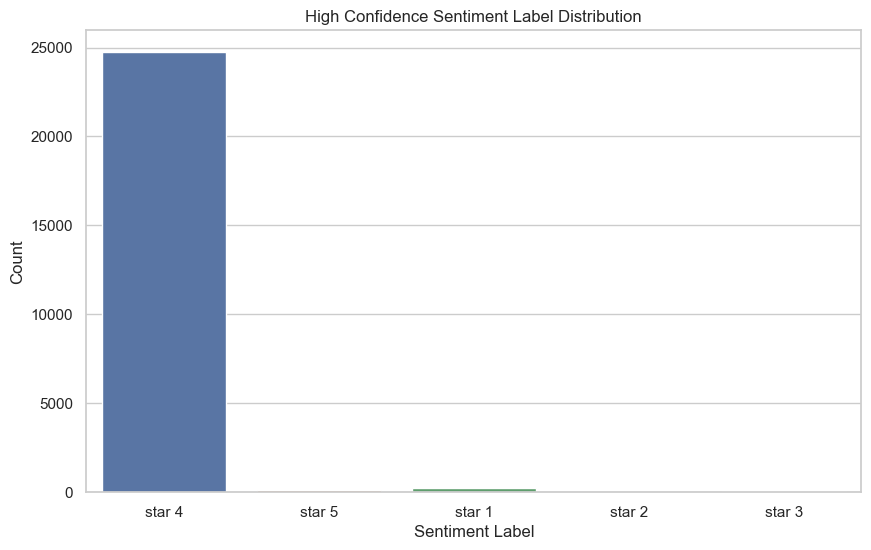

In [57]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 繪製置信度較高的情感標籤的分佈柱狀圖
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=high_confidence_df)
plt.title('High Confidence Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

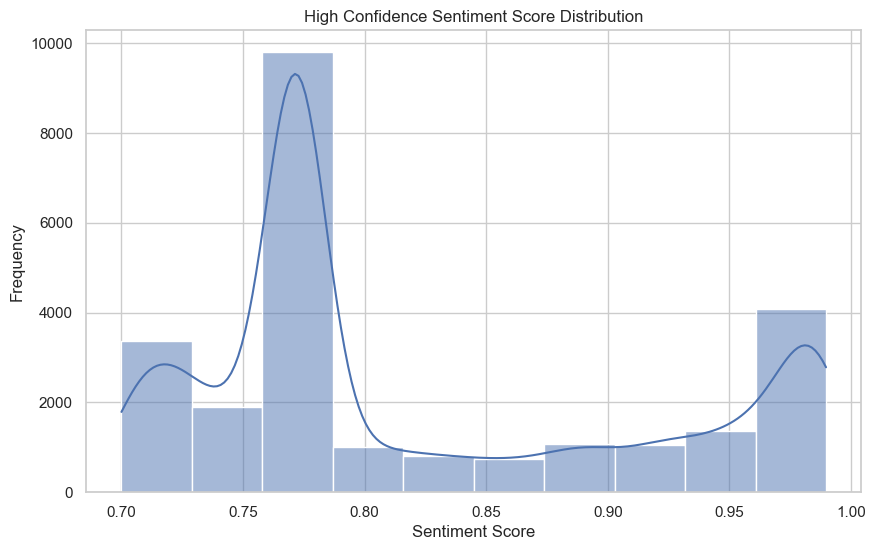

In [58]:
# 繪製置信度較高的情感分數的分佈直方圖
plt.figure(figsize=(10, 6))
sns.histplot(high_confidence_df['score'], bins=10, kde=True)
plt.title('High Confidence Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

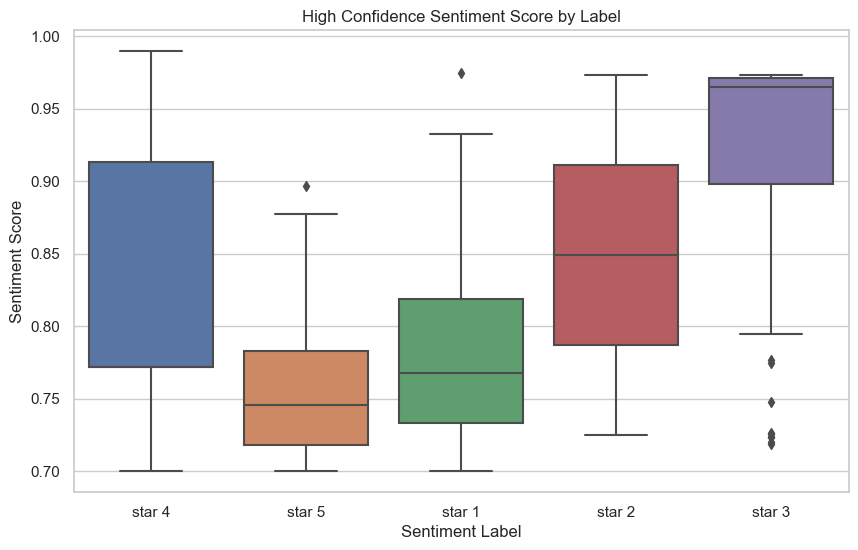

In [59]:
# 繪製置信度較高的情感分數隨情感標籤的箱線圖
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='score', data=high_confidence_df)
plt.title('High Confidence Sentiment Score by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()

### 1. High Confidence Sentiment Label Distribution
從第一張圖中可以看到：
- Star 4 的標籤數量遠遠超過其他標籤，這意味著在高置信度預測中，絕大多數的情感被分類為`Star 4`。
- 其他標籤（如`Star 5`、`Star 1`、`Star 2`、`Star 3`）的數量非常少，幾乎可以忽略不計。

這表明在高置信度預測中，情感主要被視為正面。

### 2. High Confidence Sentiment Score Distribution
從第二張圖中可以看到：
- 高置信度的情感分數主要集中在0.75和0.95之間，特別是0.75左右的分數占了大多數。
- 分數在0.85到0.95之間有明顯的增多，並且在0.95到1.0之間有另一個小高峰。

這意味著在高置信度預測中，模型對情感分類有較高的置信度。

### 3. High Confidence Sentiment Score by Label
從第三張圖中可以看到：
- Star 4 的情感分數範圍較廣，中位數較高，大約在0.85左右，顯示出這類標籤的置信度較高。
- Star 5 的情感分數中位數在0.75左右，且範圍較窄。
- Star 1、Star 2 和 Star 3 的情感分數範圍較廣，但中位數接近0.8到0.85之間。

從高置信度情感標籤分佈圖可以看出，絕大多數的句子被標記為Star 4，這表明這些句子表達了較為正面的情感。這意味著PTT社群工作版對於人工智慧相關的態度普遍是積極和樂觀的。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Sentiment Labels Over Time for sentence level 情感標籤隨時間變化（句子級別）</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Sentiment Labels Over Time 情感標籤隨時間變化</div>

In [66]:
sentiment_df['artDate'] = pd.to_datetime(sentiment_df['artDate'])

<Figure size 1400x700 with 0 Axes>

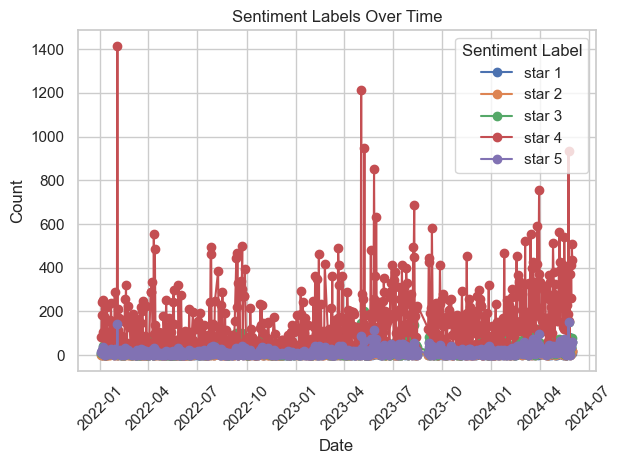

In [86]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = sentiment_df.groupby([sentiment_df['artDate'].dt.date, 'label']).size().unstack().fillna(0)

# 繪製折線圖
plt.figure(figsize=(14, 7))
daily_counts.plot(kind='line', marker='o')
plt.title('Sentiment Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Sentiment Labels Over Time with Rolling Average 情感標籤隨時間變化（移動平均線）</div>

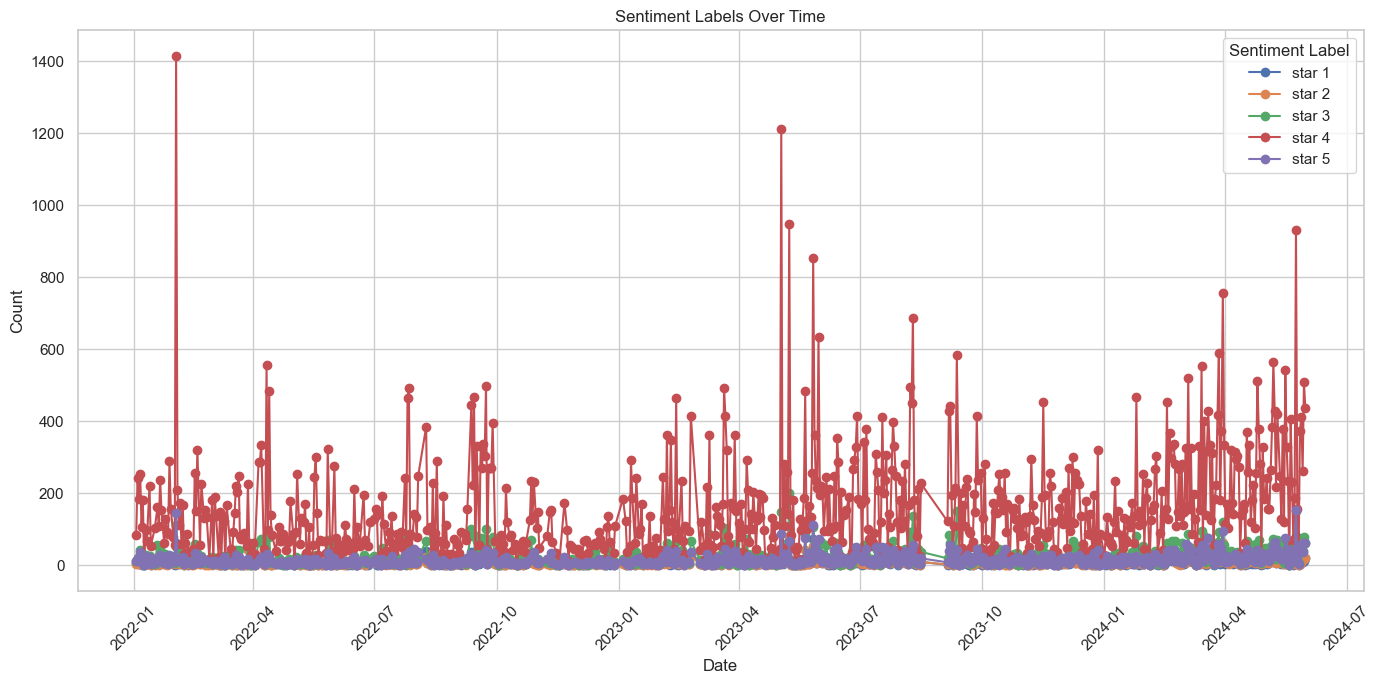

In [75]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = sentiment_df.groupby([sentiment_df['artDate'].dt.to_period('D'), 'label']).size().unstack().fillna(0)

# 將 PeriodIndex 轉換為日期字符串
daily_counts.index = daily_counts.index.to_timestamp()

# 繪製折線圖
plt.figure(figsize=(14, 7))
for column in daily_counts.columns:
    plt.plot(daily_counts.index, daily_counts[column], marker='o', label=column)

plt.title('Sentiment Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Binary Sentiment Labels Over Time 情感標籤隨時間變化（二元情感標籤）</div>

In [78]:
binary_sentiment_df = sentiment_df.copy()

# Mapping labels to binary sentiment labels
binary_sentiment_df['binary_label'] = binary_sentiment_df['label'].map({'star 1': 'Negative', 'star 2': 'Negative', 'star 3': 'Neutral', 'star 4': 'Positive', 'star 5': 'Positive'})

binary_sentiment_df.head()

,artTitle,artDate,artContent,sentence,label,score,binary_label
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習,star 4,0.628665,Positive
1,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,公司名稱普匯金融科技,star 4,0.446098,Positive
2,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺,star 4,0.833312,Positive
3,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,徵求條件,star 4,0.897125,Positive
4,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15 17:29:30,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,商管相關科系或曾經接觸相關領域,star 4,0.690813,Positive


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Binary Sentiment Labels Over Time 情感標籤隨時間變化（二元情感標籤）</div>

<Figure size 2000x700 with 0 Axes>

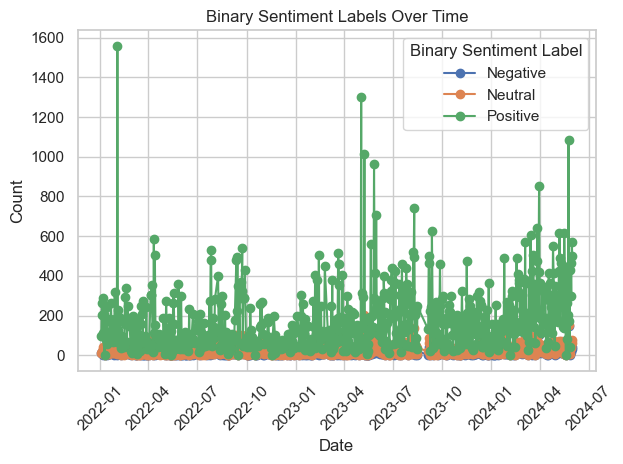

In [85]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = binary_sentiment_df.groupby([binary_sentiment_df['artDate'].dt.date, 'binary_label']).size().unstack().fillna(0)

# 繪製折線圖
plt.figure(figsize=(20, 7))
daily_counts.plot(kind='line', marker='o')
plt.title('Binary Sentiment Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Binary Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Binary Sentiment Labels Over Time with Rolling Average 情感標籤隨時間變化（移動平均線）</div>

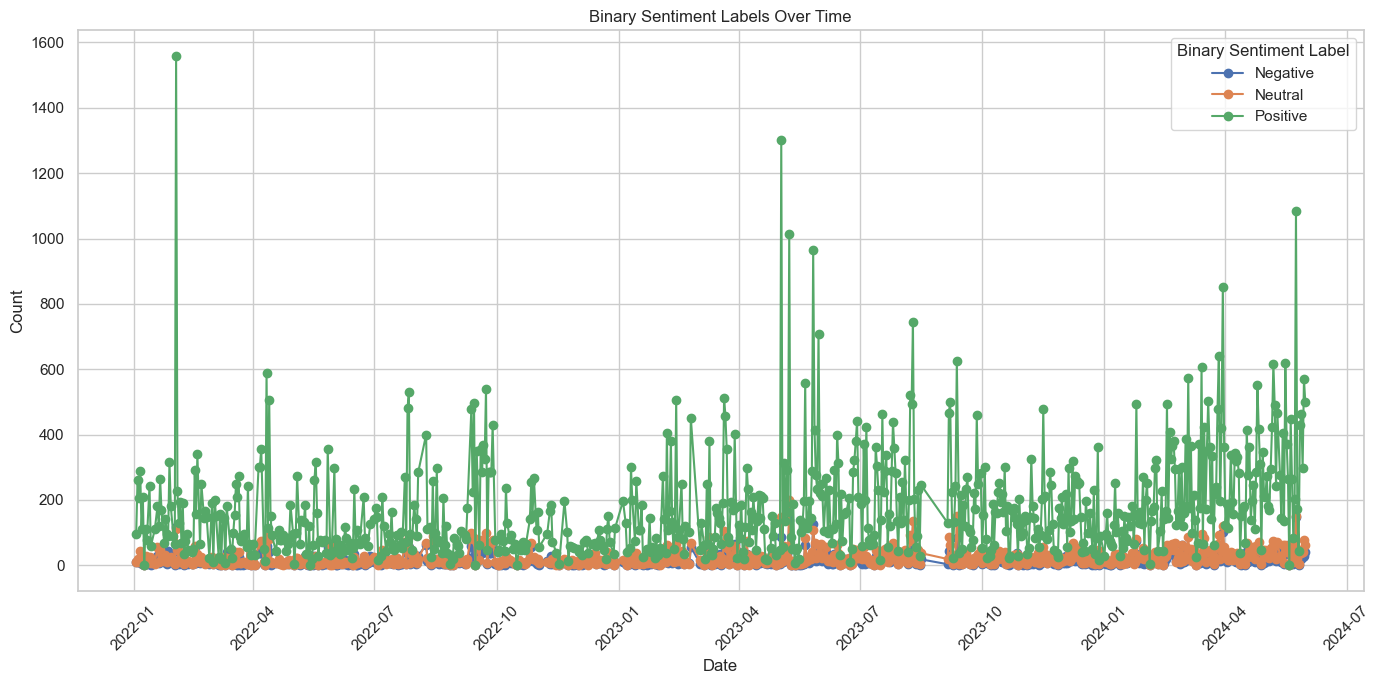

In [80]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = binary_sentiment_df.groupby([binary_sentiment_df['artDate'].dt.to_period('D'), 'binary_label']).size().unstack().fillna(0)

# 將 PeriodIndex 轉換為日期字符串
daily_counts.index = daily_counts.index.to_timestamp()

# 繪製折線圖
plt.figure(figsize=(14, 7))
for column in daily_counts.columns:
    plt.plot(daily_counts.index, daily_counts[column], marker='o', label=column)
    
plt.title('Binary Sentiment Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Binary Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Sentiment Labels Over Time for article level 情感標籤隨時間變化（文章級別）</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Weighted Average Sentiment Label 加權平均情感標籤</div>

In [87]:
# 加權平均函數
def weighted_average(group):
    weighted_scores = group.groupby('label')['score'].sum()
    return weighted_scores.idxmax()

In [88]:
# 計算文章的加權平均情感標籤
article_weighted_average = sentiment_df.groupby(['artTitle', 'artDate']).apply(weighted_average).reset_index(name='label')

article_weighted_average.head()

,artTitle,artDate,label
0,Fw:[南部]成功數據科學研究所許志仲老師徵研究助理,2022-08-24 19:20:53,star 4
1,Fw:[南部]成大數據科學研究所ACVLab徵求博士後研究,2022-04-11 00:20:29,star 4
2,Fw:[南部]成大數據科學研究所ACVLab徵計畫研究助理,2022-04-11 00:20:47,star 4
3,Fw:[徵才]KLA科磊AISupportEngineer(派遺),2022-04-14 08:31:58,star 4
4,Fw:[徵求]北商大會計資訊系陸裕豪老師誠徵兼任研究助理,2022-08-28 16:25:45,star 4


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Weighted Average Sentiment Label Over Time 加權平均情感標籤隨時間變化</div>

<Figure size 1400x700 with 0 Axes>

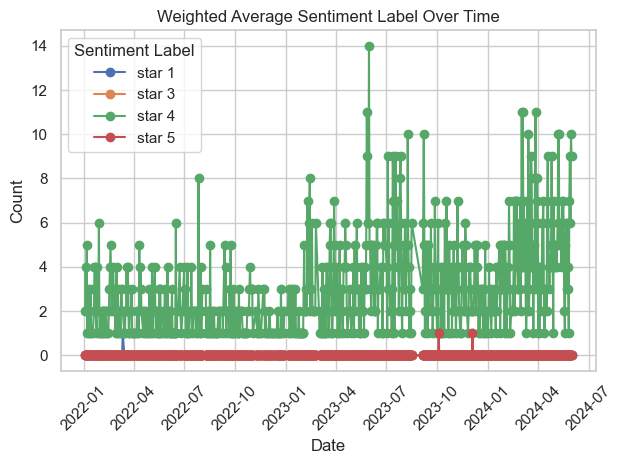

In [89]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = article_weighted_average.groupby([article_weighted_average['artDate'].dt.date, 'label']).size().unstack().fillna(0)

# 繪製折線圖
plt.figure(figsize=(14, 7))
daily_counts.plot(kind='line', marker='o')
plt.title('Weighted Average Sentiment Label Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

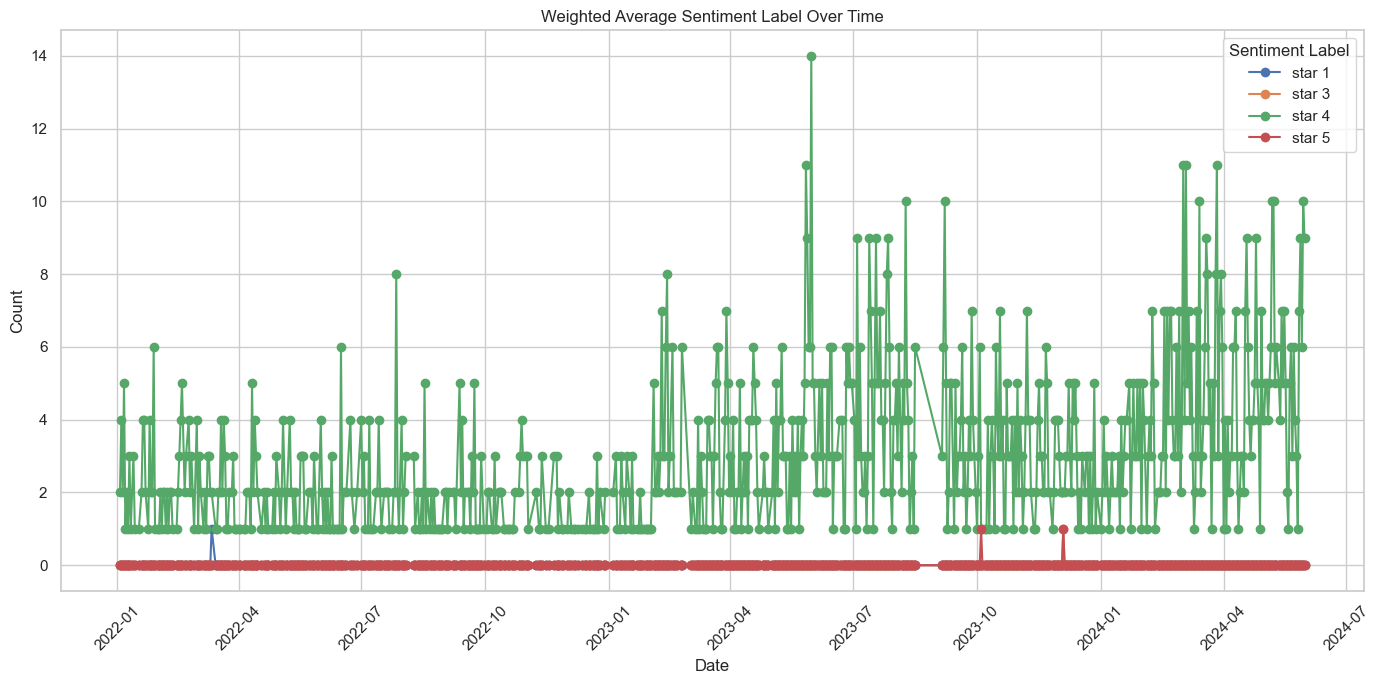

In [90]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = article_weighted_average.groupby([article_weighted_average['artDate'].dt.to_period('D'), 'label']).size().unstack().fillna(0)

# 將 PeriodIndex 轉換為日期字符串
daily_counts.index = daily_counts.index.to_timestamp()

# 繪製折線圖
plt.figure(figsize=(14, 7))
for column in daily_counts.columns:
    plt.plot(daily_counts.index, daily_counts[column], marker='o', label=column)
    
plt.title('Weighted Average Sentiment Label Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [91]:
# 換成二元情感標籤
article_binary_weighted_average = article_weighted_average.copy()

# Mapping labels to binary sentiment labels
article_binary_weighted_average['binary_label'] = article_binary_weighted_average['label'].map({'star 1': 'Negative', 'star 2': 'Negative', 'star 3': 'Neutral', 'star 4': 'Positive', 'star 5': 'Positive'})

article_binary_weighted_average.head()

,artTitle,artDate,label,binary_label
0,Fw:[南部]成功數據科學研究所許志仲老師徵研究助理,2022-08-24 19:20:53,star 4,Positive
1,Fw:[南部]成大數據科學研究所ACVLab徵求博士後研究,2022-04-11 00:20:29,star 4,Positive
2,Fw:[南部]成大數據科學研究所ACVLab徵計畫研究助理,2022-04-11 00:20:47,star 4,Positive
3,Fw:[徵才]KLA科磊AISupportEngineer(派遺),2022-04-14 08:31:58,star 4,Positive
4,Fw:[徵求]北商大會計資訊系陸裕豪老師誠徵兼任研究助理,2022-08-28 16:25:45,star 4,Positive


<Figure size 2000x700 with 0 Axes>

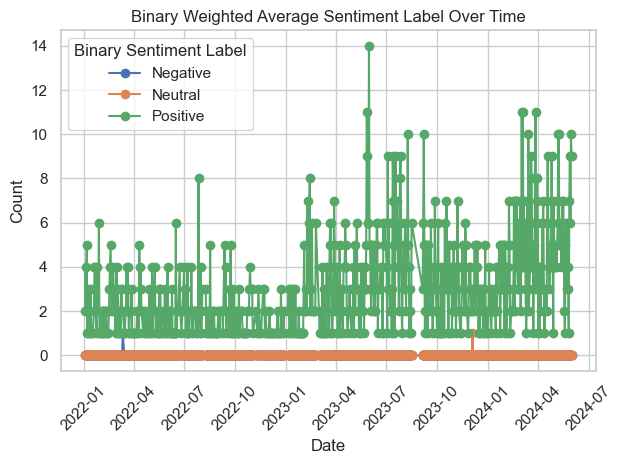

In [92]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = article_binary_weighted_average.groupby([article_binary_weighted_average['artDate'].dt.date, 'binary_label']).size().unstack().fillna(0)

# 繪製折線圖
plt.figure(figsize=(20, 7))
daily_counts.plot(kind='line', marker='o')
plt.title('Binary Weighted Average Sentiment Label Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Binary Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

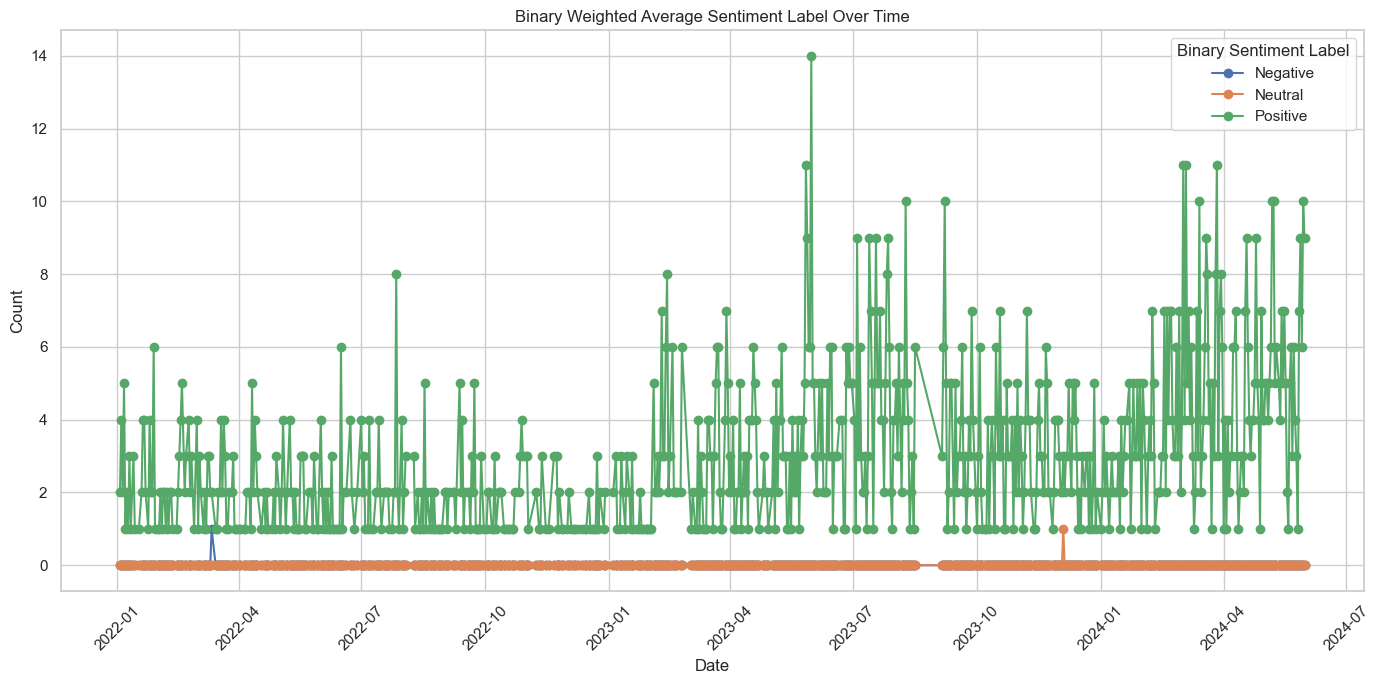

In [93]:
# 設置繪圖風格
sns.set(style="whitegrid")

# 按日期聚合數據
daily_counts = article_binary_weighted_average.groupby([article_binary_weighted_average['artDate'].dt.to_period('D'), 'binary_label']).size().unstack().fillna(0)

# 將 PeriodIndex 轉換為日期字符串
daily_counts.index = daily_counts.index.to_timestamp()

# 繪製折線圖
plt.figure(figsize=(14, 7))
for column in daily_counts.columns:
    plt.plot(daily_counts.index, daily_counts[column], marker='o', label=column)
    
plt.title('Binary Weighted Average Sentiment Label Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Binary Sentiment Label')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

由上方觀察，大多數文章也是被標記為Star 4，這表明這些文章表達了較為正面的情感。這說明有關招聘的文章在PTT社群工作版上的情感傾向是積極和樂觀的。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Analysis of Sentiment Samples 情感樣本分析</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Filtering Positive and Negative Sentences 篩選正面和負面句子</div>

In [107]:
# 篩選出正面和負面
positive_sentences = article_binary_weighted_average[article_binary_weighted_average['label'].isin(['star 4', 'star 5'])]
negative_sentences = article_binary_weighted_average[article_binary_weighted_average['label'].isin(['star 1', 'star 2'])]

In [108]:
# 顯示正面句子
positive_sentences.head()

,artTitle,artDate,label,binary_label
0,Fw:[南部]成功數據科學研究所許志仲老師徵研究助理,2022-08-24 19:20:53,star 4,Positive
1,Fw:[南部]成大數據科學研究所ACVLab徵求博士後研究,2022-04-11 00:20:29,star 4,Positive
2,Fw:[南部]成大數據科學研究所ACVLab徵計畫研究助理,2022-04-11 00:20:47,star 4,Positive
3,Fw:[徵才]KLA科磊AISupportEngineer(派遺),2022-04-14 08:31:58,star 4,Positive
4,Fw:[徵求]北商大會計資訊系陸裕豪老師誠徵兼任研究助理,2022-08-28 16:25:45,star 4,Positive


In [109]:
# 顯示負面句子
negative_sentences.head()

,artTitle,artDate,label,binary_label
299,[心得]萬達人工智慧極度不推分享,2022-03-12 20:27:26,star 1,Negative


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">View Positive Sentences 查看正面句子</div>

In [117]:
# 查看該正面句子的文章
positive_article = clear_df[clear_df['artTitle'].isin(positive_sentences['artTitle'])][['artTitle', 'artContent']].drop_duplicates()

positive_article.head()

,artTitle,artContent
0,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...
1,[新聞]台銀「三駕馬車」戰略發威前4月,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...
2,[新聞]央行徵才月薪最高86K,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...
3,[新聞]證交所徵才開創數位驅動時代報名至11/17,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...
4,[台中][西屯］飛斯戴爾有限公司/日文客服,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...


In [118]:
for i in range(5):
    print(positive_article['artContent'].values[i])
    print('='*50)

【實習】
【公司名稱】Influx FinTech 普匯金融科技

【工作職缺】Fintech Marketing Intern/ Fiance Intern
【徵求條件】
1.商管相關科系或曾經接觸相關Fintech領域
2.關注時事議題，對國內外金融科技趨勢議題有興趣
3.熟悉 Office 軟體、社群軟體，具圖文影音創作能力者額外加分
4.具 Adobe illustrator / Adobe Photoshop / Adobe Premiere 經驗者額外加分
5.有操作過線上／線下行銷活動或自媒體經營經驗者額外加分

【薪資待遇】實習168元/hr
【連絡方式】104投遞履歷
【工作地點】台北市中山區松江路111號11樓之1
【工作時間】一週三天（可議）09:00~12:30 13:30~18:00（午休一小時）
【工作內容】
1.Mentor指導協助廣告投放
2.社群經營包含圖文撰寫
3.Fintech 行銷及產品提案與執行
4.市場數據蒐集與分析

【公司福利】三節獎品
【其他備註】公司簡介（
https://bit.ly/3JsFOAP
）
普匯金融科技由具備多年專業風險管理、金融產品設計及高端科技團隊組成，提供互利互
信、公開透明、有溫度的金融服務，立志串起社會閒置資源，協助年輕人完成夢想的金融
新平台。
我們是一支最具「速度、紀律、績效」的團隊，邀請您一起加入開創年輕化的移動金融服
務，共同邁向國際舞台，創立AI金融科技獨角獸！
我們在做：
1.利用高端科技P2P、AI人工智慧、區塊鏈技術，提供個人、中小企業、汽車融資等線上
借貸及債權投資媒合服務
2.創新開發金融產品
3.跨業策略聯盟與AI金融科技聯盟
4.合作台大兒童健康基金會並由張鈞甯擔任公益大使舉辦聯合勸募捐款社會公益

心動了嗎？趕緊上104投遞履歷吧！
→
https://bit.ly/3gFz5r9
（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威
，董事長呂桔誠今天表示，台銀今年前4月稅前淨利達新台幣54億元，加上政策性負擔，
總額來到85億元，已達年度預算數52%。

台灣銀行經濟金融論文獎頒獎典暨經濟研究所揭牌儀式今天登場，呂桔誠、總統府資政陳
博志等人出席。

呂桔誠接受媒體聯訪時指出，台銀今年1至4月稅前淨利達54億元，若加上政策性負擔31

這些都是徵人文，內容通常是積極和樂觀的，而有關公司的介紹和工作內容也是正面的。這也是為什麼這些文章被標記為正面情感的原因。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">View Negative Sentences 查看負面句子</div>

In [115]:
# 查看該負面句子的文章
negative_article = clear_df[clear_df['artTitle'].isin(negative_sentences['artTitle'])][['artTitle', 'artContent']].drop_duplicates()

negative_article.head()

,artTitle,artContent
144,[心得]萬達人工智慧極度不推分享,先說明我從頭到尾就已後端工程師為職涯目標，\n\n所以在面試的時候顧問問我要不要當unity...


In [116]:
print(negative_article['artContent'].values[0])

先說明我從頭到尾就已後端工程師為職涯目標，

所以在面試的時候顧問問我要不要當unity工程師我也是嚴正拒絕，

因此offer拿到的也是後端工程師的職缺，

但是在那家公司做的事很雜，一開始以為自己是devops

而且主管不知道在幹嘛，我才進去沒多久就要離職，

一個禮拜來兩三天，所以變成我做事然後跟他報告進度，

他根本沒在做事只忙沒用的交接文件，而且根本沒跟我交接，




然後在某一天，顧問突然來找說話，說他是因為我有寫過前端經驗才找我，

但....我不是在面試就拒絕當unity工程師了嗎?

我真的很不懂這家公司在想甚麼

找UI/UX當QA 還要找後端寫unity嗎?




不過應該沒有老闆兼PM企劃更恐怖....

老闆在某天突然拿著一天我看不懂的spec....

說要存user password到log的spec.....

更不用說其他不清不楚的規格

還說他跟主管討論過

我都想說主管為甚麼不跟我討論

我突然覺得墜入地獄

還問我不懂在哪怎麼做不出來

狂槌我桌子

他就一直複製主管對我說過的話 但主管自己都做不出來

當下我就火了


隔天顧問就說我要檢討自己的態度，

spec不好是另外的事，

還拿出他是台大碩士畢業來說嘴，

最後說如果我們不能配合就到今天結束，



不過我看主管對我做的不滿意，

他最後也是沒想出來要怎麼做。




而且明明是小公司卻還要用軟體螢幕監控員工。





由此可以看出這篇是偏抱怨工作offer與實際工作內容不符的文章，這也是為什麼被標記為負面情感的原因。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: Conclusion 結論</div>

有關 Bert 情感分析的結果，我們得出以下結論：

1. 雖然大多數文章和句子被標記為 Star 4，但很多句子都是不具有情感的，這可能是因為 Bert 模型在處理中文文本時的一些限制。
   - 例如: "公司名稱普匯金融科技" 這句話被標記為 Star 4，但實際上並沒有情感。
2. 在高置信度預測中，絕大多數的情感被分類為 Star 4，這表明在高置信度預測中，情感主要被視為正面。但是，由樣本分析可以看出，有些情感標籤可能不準確。
3. 大多數文章也是被標記為 Star 4，這表明這些文章表達了較為正面的情感。這可能原因是應召文的內容通常是積極和樂觀的。
4. 有些文章被標記為負面情感，這可能是因為文章中包含了一些負面的詞語或情感。這些文章可能包含了一些抱怨或不滿的內容。